In [45]:
import pandas as pd
import numpy as np
import pandasql as sqldf
import datetime
import matplotlib.pyplot as plt
import sys,os
from sklearn.model_selection import train_test_split

**Einlesen und abspeichern:**

In [46]:
csv_filenames = []
#auslesen aller csv file dateinamen aus formula 1 datensatz und abspeichern in liste
for filename in os.listdir(os.getcwd()):
    typ = filename.split('.')[-1]
    name = filename.split('.')[0]
    if typ == 'csv':
        csv_filenames.append(filename)
csv_filenames

['circuits.csv',
 'constructorResults.csv',
 'constructors.csv',
 'constructorStandings.csv',
 'drivers.csv',
 'driverStandings.csv',
 'lapTimes.csv',
 'pitStops.csv',
 'qualifying.csv',
 'races.csv',
 'results.csv',
 'seasons.csv',
 'status.csv']

In [47]:
all_dfs = {}
#einlesen und abspeichern als dataframe aller dateien
for file in csv_filenames:
    print(file)
    try:
        df = pd.read_csv(file, engine = 'python', sep = ',')
    except Exception as e:
        df = pd.read_csv(file, engine = 'c', sep = ',')
        print(e)
    #print(df.head())
    all_dfs[file] = df

circuits.csv
constructorResults.csv
constructors.csv
constructorStandings.csv
drivers.csv
driverStandings.csv
lapTimes.csv
pitStops.csv
qualifying.csv
NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
races.csv
NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead
results.csv
seasons.csv
status.csv


**Zusammenmatschen der DataFrames**

In [48]:
laps = all_dfs['lapTimes.csv']
drivers = all_dfs['drivers.csv']
races = all_dfs['races.csv']
result = all_dfs['results.csv']
constructor = all_dfs['constructors.csv']
len(laps)

426633

In [49]:
merged_df = sqldf.sqldf("""select 
            t1.raceId,
            t1.year,
            --t1.round as race_round_number,
            t1.circuitId, 
            t1.name as grandprix_name,
            --t1.date,
            --t1.time as race_time,
            --t2.round as round_number,
            t2.driverId,
            t2.lap as lap_number,
            t2.position as lap_position,
            --t2.time as lap_time,
            t2.milliseconds as lap_in_milliseconds,
            --t2.driverRef,
            --t2.number as driver_number,
            --t2.code as driver_code,
            --t2.forename,
            --t2.surname,
            t2.driver_fullname
            --t2.dob as driver_dob,
            --t2.nationality as driver_nationality
            from 
            races t1 join (select 
                d1.*,
                d2.driverRef,
                d2.number,
                d2.code,
                d2.forename,
                d2.surname,
                d2.forename||' '||d2.surname as driver_fullname,
                d2.dob,
                d2.nationality
               -- d2.url
                from laps d1 join drivers d2
                on d1.driverId=d2.driverId) t2
            on t1.raceId=t2.raceId
            order by t1.raceId
            """)
merged_df.head()

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname
0,1,2009,1,Australian Grand Prix,1,1,13,109088,Lewis Hamilton
1,1,2009,1,Australian Grand Prix,1,2,12,93740,Lewis Hamilton
2,1,2009,1,Australian Grand Prix,1,3,11,91600,Lewis Hamilton
3,1,2009,1,Australian Grand Prix,1,4,10,91067,Lewis Hamilton
4,1,2009,1,Australian Grand Prix,1,5,10,92129,Lewis Hamilton


In [50]:
#test = merged_df.join(result, on = ['raceId', 'driverId'], how = 'inner')
test = pd.merge(merged_df,result[['raceId', 'driverId','position', 'constructorId']], on=['raceId','driverId'])
test.head()

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,position,constructorId
0,1,2009,1,Australian Grand Prix,1,1,13,109088,Lewis Hamilton,NaN,1
1,1,2009,1,Australian Grand Prix,1,2,12,93740,Lewis Hamilton,NaN,1
2,1,2009,1,Australian Grand Prix,1,3,11,91600,Lewis Hamilton,NaN,1
3,1,2009,1,Australian Grand Prix,1,4,10,91067,Lewis Hamilton,NaN,1
4,1,2009,1,Australian Grand Prix,1,5,10,92129,Lewis Hamilton,NaN,1


In [51]:
fin = pd.merge(test, constructor[['constructorId', 'name']], on = 'constructorId')
try:
    del fin['name_x']
    del fin['name_y']
except Exception as e:
    print(e)
fin.rename(columns = {'name': 'constructor_name', 'position':'podium_position'}, inplace = True)
fin.head()

'name_x'


,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name
0,1,2009,1,Australian Grand Prix,1,1,13,109088,Lewis Hamilton,NaN,1,McLaren
1,1,2009,1,Australian Grand Prix,1,2,12,93740,Lewis Hamilton,NaN,1,McLaren
2,1,2009,1,Australian Grand Prix,1,3,11,91600,Lewis Hamilton,NaN,1,McLaren
3,1,2009,1,Australian Grand Prix,1,4,10,91067,Lewis Hamilton,NaN,1,McLaren
4,1,2009,1,Australian Grand Prix,1,5,10,92129,Lewis Hamilton,NaN,1,McLaren


**Pitstops**

In [52]:
pits = all_dfs["pitStops.csv"]
pits["stop_binary"] = 1
pits.rename(columns = {"lap": "lap_number"}, inplace = True)
fin = pd.merge(fin, pits[['raceId', 'driverId', 'lap_number', 'stop_binary']], on = ['raceId','driverId', 'lap_number'], how = "outer")
fin_newage = fin.where(fin.year >= 2011).dropna(how = "all")
fin_newage["stop_binary"] = fin_newage["stop_binary"].replace(np.nan, 0)
fin_newage.head(20)


,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary
26621,841.0,2011.0,1.0,Australian Grand Prix,1.0,1.0,2.0,100573.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26622,841.0,2011.0,1.0,Australian Grand Prix,1.0,2.0,2.0,93774.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26623,841.0,2011.0,1.0,Australian Grand Prix,1.0,3.0,2.0,92900.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26624,841.0,2011.0,1.0,Australian Grand Prix,1.0,4.0,2.0,92582.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26625,841.0,2011.0,1.0,Australian Grand Prix,1.0,5.0,2.0,92471.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26626,841.0,2011.0,1.0,Australian Grand Prix,1.0,6.0,2.0,92434.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26627,841.0,2011.0,1.0,Australian Grand Prix,1.0,7.0,2.0,92447.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26628,841.0,2011.0,1.0,Australian Grand Prix,1.0,8.0,2.0,92310.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26629,841.0,2011.0,1.0,Australian Grand Prix,1.0,9.0,2.0,92612.0,Lewis Hamilton,2.0,1.0,McLaren,0.0
26630,841.0,2011.0,1.0,Australian Grand Prix,1.0,10.0,2.0,93121.0,Lewis Hamilton,2.0,1.0,McLaren,0.0


**Max Runden**

In [53]:
Penis = sqldf.sqldf("""
                            select *, max(lap_number) as total_laps
                            from fin_newage group by raceId """)
Penis.head()

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary,total_laps
0,841.0,2011.0,1.0,Australian Grand Prix,1.0,58.0,2.0,94576.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0
1,842.0,2011.0,2.0,Malaysian Grand Prix,1.0,56.0,7.0,101776.0,Lewis Hamilton,8.0,1.0,McLaren,0.0,56.0
2,843.0,2011.0,17.0,Chinese Grand Prix,1.0,56.0,1.0,103142.0,Lewis Hamilton,1.0,1.0,McLaren,0.0,56.0
3,844.0,2011.0,5.0,Turkish Grand Prix,1.0,58.0,4.0,91292.0,Lewis Hamilton,4.0,1.0,McLaren,0.0,58.0
4,845.0,2011.0,4.0,Spanish Grand Prix,1.0,66.0,2.0,88202.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,66.0


In [54]:
fin_newage = pd.merge(fin_newage, Penis[['raceId', 'total_laps']], on ='raceId', how = "outer")


In [55]:
fin_newage["race_completion"] = fin_newage["lap_number"]/fin_newage["total_laps"]
fin_newage.head(58)

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary,total_laps,race_completion
0,841.0,2011.0,1.0,Australian Grand Prix,1.0,1.0,2.0,100573.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.017241
1,841.0,2011.0,1.0,Australian Grand Prix,1.0,2.0,2.0,93774.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.034483
2,841.0,2011.0,1.0,Australian Grand Prix,1.0,3.0,2.0,92900.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.051724
3,841.0,2011.0,1.0,Australian Grand Prix,1.0,4.0,2.0,92582.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.068966
4,841.0,2011.0,1.0,Australian Grand Prix,1.0,5.0,2.0,92471.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.086207
5,841.0,2011.0,1.0,Australian Grand Prix,1.0,6.0,2.0,92434.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.103448
6,841.0,2011.0,1.0,Australian Grand Prix,1.0,7.0,2.0,92447.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.120690
7,841.0,2011.0,1.0,Australian Grand Prix,1.0,8.0,2.0,92310.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.137931
8,841.0,2011.0,1.0,Australian Grand Prix,1.0,9.0,2.0,92612.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.155172
9,841.0,2011.0,1.0,Australian Grand Prix,1.0,10.0,2.0,93121.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.172414


In [56]:
results = all_dfs["results.csv"]
status = all_dfs["status.csv"]

In [57]:
status.columns

Index(['statusId', 'status'], dtype='object')

In [58]:
results = pd.merge(results, status[['statusId', 'status']], on ='statusId', how = "outer")
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,status
0,1.0,18.0,1.0,1.0,22.0,1.0,1.0,1,1.0,10.0,58.0,34:50.6,5690616.0,39.0,2.0,01:27.5,218.3,1,Finished
1,2.0,18.0,2.0,2.0,3.0,5.0,2.0,2,2.0,8.0,58.0,5.478,5696094.0,41.0,3.0,01:27.7,217.586,1,Finished
2,3.0,18.0,3.0,3.0,7.0,7.0,3.0,3,3.0,6.0,58.0,8.163,5698779.0,41.0,5.0,01:28.1,216.719,1,Finished
3,4.0,18.0,4.0,4.0,5.0,11.0,4.0,4,4.0,5.0,58.0,17.181,5707797.0,58.0,7.0,01:28.6,215.464,1,Finished
4,5.0,18.0,5.0,1.0,23.0,3.0,5.0,5,5.0,4.0,58.0,18.014,5708630.0,43.0,1.0,01:27.4,218.385,1,Finished


In [59]:
status_ding = sqldf.sqldf(""" select * from results where raceId >= 841""")

#anlegen einer temporären Spalte, die anzahl der überrundeten Runden enthält, bzw. sinnfrei zerschnittene strings
status_ding["count_laps"] = status_ding.status.apply(lambda y: y.split()[0][1:])

def conv_int(x):
    #konvertieren des eintrags in den typ integer, um später vergleich vornehmen zu können
    try:
        x = int(x)
    except:
        #fall kommt nur vor wenn keine überrundung stattgefunden hat, also im generellen DNF fall oder Finished
        x = 1000
        
    return x
#anwenden der conv_int funktion auf die zuvor erzeugte temp spalte
status_ding["count_laps"] = status_ding.count_laps.apply(lambda y: conv_int(y))       

#hinzufügen der spalte sttatus_clean, mit nur drei Merkmalsausprägungen Finished, lapped und DNF
status_ding["status_clean"] = ['Finished' if status_ding.at[v,"status"] == 'Finished' else 'lapped' if (status_ding.at[v,"status"].startswith('+') and status_ding.at[v,"count_laps"] <= 3)else 'DNF' for v in range(len(status_ding.status))]

In [60]:
status_ding.head(30)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,status,count_laps,status_clean
0,20779.0,841.0,20.0,9.0,1.0,1.0,1.0,1,1.0,25.0,...,29:30.3,5370259.0,44.0,4.0,01:29.8,212.488,1,Finished,1000,Finished
1,20780.0,841.0,1.0,1.0,3.0,2.0,2.0,2,2.0,18.0,...,22.297,5392556.0,41.0,8.0,01:30.3,211.382,1,Finished,1000,Finished
2,20781.0,841.0,808.0,4.0,10.0,6.0,3.0,3,3.0,15.0,...,30.56,5400819.0,55.0,7.0,01:30.1,211.969,1,Finished,1000,Finished
3,20782.0,841.0,4.0,6.0,5.0,5.0,4.0,4,4.0,12.0,...,31.772,5402031.0,49.0,2.0,01:29.5,213.336,1,Finished,1000,Finished
4,20783.0,841.0,17.0,9.0,2.0,3.0,5.0,5,5.0,10.0,...,38.171,5408430.0,50.0,3.0,01:29.6,213.066,1,Finished,1000,Finished
5,20784.0,841.0,18.0,1.0,4.0,4.0,6.0,6,6.0,8.0,...,54.304,5424563.0,49.0,5.0,01:29.9,212.396,1,Finished,1000,Finished
6,20785.0,841.0,13.0,6.0,6.0,8.0,7.0,7,7.0,6.0,...,+1:25.186,5455445.0,55.0,1.0,01:28.9,214.631,1,Finished,1000,Finished
7,20801.0,842.0,20.0,9.0,1.0,1.0,1.0,1,1.0,25.0,...,37:39.8,5859832.0,33.0,6.0,01:41.5,196.523,1,Finished,1000,Finished
8,20802.0,842.0,18.0,1.0,4.0,4.0,2.0,2,2.0,18.0,...,3.261,5863093.0,50.0,4.0,01:41.3,197.057,1,Finished,1000,Finished
9,20803.0,842.0,2.0,4.0,9.0,6.0,3.0,3,3.0,15.0,...,25.075,5884907.0,47.0,7.0,01:41.5,196.508,1,Finished,1000,Finished


In [61]:
#zusammenführen von status informationen und bisherigem dataframe
fin_newage = pd.merge(fin_newage, status_ding[['raceId', 'driverId', 'grid', 'status_clean', 'count_laps']], on = ['raceId', 'driverId'])
fin_newage.head()

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary,total_laps,race_completion,grid,status_clean,count_laps
0,841.0,2011.0,1.0,Australian Grand Prix,1.0,1.0,2.0,100573.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.017241,2.0,Finished,1000
1,841.0,2011.0,1.0,Australian Grand Prix,1.0,2.0,2.0,93774.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.034483,2.0,Finished,1000
2,841.0,2011.0,1.0,Australian Grand Prix,1.0,3.0,2.0,92900.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.051724,2.0,Finished,1000
3,841.0,2011.0,1.0,Australian Grand Prix,1.0,4.0,2.0,92582.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.068966,2.0,Finished,1000
4,841.0,2011.0,1.0,Australian Grand Prix,1.0,5.0,2.0,92471.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.086207,2.0,Finished,1000


In [62]:
t = sqldf.sqldf("""select *, sum(lap_in_milliseconds) as total_milliseconds_temp
                from fin_newage
                group by raceId, driverId""")

t['total_milliseconds'] = [t.at[x, 'total_milliseconds_temp'] if t.at[x,'count_laps'] == 1000 else t.at[x, 'total_milliseconds_temp']+(t.at[x, 'total_milliseconds_temp']/(t.at[x, 'total_laps']- t.at[x, 'count_laps']))*t.at[x, 'count_laps'] for x in range(len(t))]
t.head(15)

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary,total_laps,race_completion,grid,status_clean,count_laps,total_milliseconds_temp,total_milliseconds
0,841.0,2011.0,1.0,Australian Grand Prix,1.0,1.0,2.0,100573.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.017241,2.0,Finished,1000,5392556.0,5.392556e+06
1,841.0,2011.0,1.0,Australian Grand Prix,2.0,1.0,13.0,112091.0,Nick Heidfeld,12.0,4.0,Renault,0.0,58.0,0.017241,18.0,lapped,1,5443901.0,5.539408e+06
2,841.0,2011.0,1.0,Australian Grand Prix,3.0,1.0,7.0,105340.0,Nico Rosberg,NaN,131.0,Mercedes,0.0,58.0,0.017241,7.0,DNF,1000,2121876.0,2.121876e+06
3,841.0,2011.0,1.0,Australian Grand Prix,4.0,1.0,9.0,106144.0,Fernando Alonso,4.0,6.0,Ferrari,0.0,58.0,0.017241,5.0,Finished,1000,5402031.0,5.402031e+06
4,841.0,2011.0,1.0,Australian Grand Prix,5.0,1.0,15.0,112883.0,Heikki Kovalainen,NaN,205.0,Lotus,0.0,58.0,0.017241,19.0,DNF,1000,1876459.0,1.876459e+06
5,841.0,2011.0,1.0,Australian Grand Prix,10.0,1.0,19.0,114969.0,Timo Glock,NaN,166.0,Virgin,0.0,58.0,0.017241,21.0,DNF,9,5462637.0,6.465978e+06
6,841.0,2011.0,1.0,Australian Grand Prix,13.0,1.0,5.0,104196.0,Felipe Massa,7.0,6.0,Ferrari,0.0,58.0,0.017241,8.0,Finished,1000,5455445.0,5.455445e+06
7,841.0,2011.0,1.0,Australian Grand Prix,15.0,1.0,17.0,114113.0,Jarno Trulli,13.0,205.0,Lotus,0.0,58.0,0.017241,20.0,lapped,2,5453536.0,5.648305e+06
8,841.0,2011.0,1.0,Australian Grand Prix,16.0,1.0,12.0,111520.0,Adrian Sutil,9.0,10.0,Force India,0.0,58.0,0.017241,16.0,lapped,1,5394794.0,5.489440e+06
9,841.0,2011.0,1.0,Australian Grand Prix,17.0,1.0,3.0,101467.0,Mark Webber,5.0,9.0,Red Bull,0.0,58.0,0.017241,3.0,Finished,1000,5408430.0,5.408430e+06


In [63]:
vorpizza = pd.merge(fin_newage, t[['raceId', 'driverId', 'total_milliseconds']], on = ['raceId', 'driverId'], how = 'outer')
del vorpizza["count_laps"]

In [64]:
vorpizza.head(15)

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary,total_laps,race_completion,grid,status_clean,total_milliseconds
0,841.0,2011.0,1.0,Australian Grand Prix,1.0,1.0,2.0,100573.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.017241,2.0,Finished,5392556.0
1,841.0,2011.0,1.0,Australian Grand Prix,1.0,2.0,2.0,93774.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.034483,2.0,Finished,5392556.0
2,841.0,2011.0,1.0,Australian Grand Prix,1.0,3.0,2.0,92900.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.051724,2.0,Finished,5392556.0
3,841.0,2011.0,1.0,Australian Grand Prix,1.0,4.0,2.0,92582.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.068966,2.0,Finished,5392556.0
4,841.0,2011.0,1.0,Australian Grand Prix,1.0,5.0,2.0,92471.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.086207,2.0,Finished,5392556.0
5,841.0,2011.0,1.0,Australian Grand Prix,1.0,6.0,2.0,92434.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.103448,2.0,Finished,5392556.0
6,841.0,2011.0,1.0,Australian Grand Prix,1.0,7.0,2.0,92447.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.120690,2.0,Finished,5392556.0
7,841.0,2011.0,1.0,Australian Grand Prix,1.0,8.0,2.0,92310.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.137931,2.0,Finished,5392556.0
8,841.0,2011.0,1.0,Australian Grand Prix,1.0,9.0,2.0,92612.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.155172,2.0,Finished,5392556.0
9,841.0,2011.0,1.0,Australian Grand Prix,1.0,10.0,2.0,93121.0,Lewis Hamilton,2.0,1.0,McLaren,0.0,58.0,0.172414,2.0,Finished,5392556.0


**Berechnen der Form für jeden Fahrer**

In [112]:
years = vorpizza.year.tolist()
years = set(years)
form_df = pd.DataFrame(columns = ["raceId", "driverId", "form"])
letzter_platz = pd.DataFrame(columns = ["year", "letzter_nummer"])
a = 0

for year in years:
    #filtern nach einem speziellen Jahr
    temp_df = vorpizza.where(vorpizza.year == year).dropna(how = "all")
    #auslesen aller Teams *2 = Anzahl der Rennteilnehmer, also schlechteste Rennposition
    constructor_count = len(sqldf.sqldf("""select distinct(constructorId)
                                    from temp_df 
                                    group by constructorId"""))*2
    #zwischenspeichern der constructor count informationen
    zeile = pd.DataFrame(columns = letzter_platz.columns)
    zeile.loc[0, :] = [year, constructor_count]
    letzter_platz = letzter_platz.append(zeile)
    temp_drivers = set(temp_df.driverId.tolist())
    for driver in temp_drivers:
        #filtern nach einem speziellen Fahrer
        temp_df2 = temp_df.where(temp_df.driverId == driver).dropna(how = "all")
        temp_df2 = sqldf.sqldf("""select raceId, driverId, podium_position from temp_df2 group by raceId order by raceId""")
        #Ersetzen der Rennen in denen DNF, also NaN mit letztem Platz constructor_count
        temp_df2.replace(np.nan, constructor_count, inplace = True)
        
        #liste mit allen rennids wird erzeugt, um zu überprüfen ob welche in Abschnitt fehlen
        start_race_id =  temp_df2.at[0, "raceId"]
        end_race_id = temp_df2.at[list(temp_df2.index)[-1], "raceId"]
        r_ids = [x for x in range(int(start_race_id), int(end_race_id)+1)]
        temp_ids = temp_df2.raceId.astype(int)
        temp_ids = temp_ids.values.tolist()
        
        #überprüfen ob alle raceIds in der Liste vorhanden sind
        if temp_ids != r_ids:
            #fehlende rennen werden in liste gespeichert
            missing = [x for x in r_ids if x not in temp_ids]
            
            for miss in missing:
                #einfügen der fehlenden raceids in den dataframe
                platzhalter = pd.DataFrame(columns = temp_df2.columns)
                #dataframe an stelle wo id fehlt aufteilen in vorher und nachher
                vorher = temp_df2.where(temp_df2.raceId < miss).dropna(how = "all")
                nachher = temp_df2.where(temp_df2.raceId > miss).dropna(how = "all")
                #erzeugen einer neuen Reihe, die fehlende id, driverId und als pp den letztmöglichen Platz enthält
                d = vorher.at[list(vorher.index)[0], "driverId"]
                platzhalter.loc[0,:] = [miss, d, constructor_count]
                vorher = vorher.append(platzhalter)
                temp_df2 = vorher.append(nachher)
                temp_df2.reset_index(inplace = True, drop = True)
                
        for i, row in temp_df2.iterrows():
            #form des fahrers anhand seiner podiums positionen der in der saison vorhergegangenen rennen bestimmen
            raceId = row["raceId"]
            driverId = row["driverId"]
            #i = 4
            if i == 0:
                form = 0
            elif i < 4:
                zaehler = temp_df2.loc[:i-1,"podium_position"].tolist()
                form = np.sum(zaehler)/i
                
            else:
                zaehler = temp_df2.loc[i-4:i-1,"podium_position"].tolist()
                form = np.sum(zaehler)/4
                
            form_df.loc[a, :] = [raceId, driverId, form]
            #print("form df", form_df)
            a += 1

In [102]:
alles = pd.merge(vorpizza, form_df, on = ["raceId", "driverId"])
alles.form = alles.form.astype(float)
alles.shape

(157755, 19)

In [111]:
#allle die nan in der podiums position haben scheinen ausgeschieden zu sein
ttt = alles.podium_position.replace(np.nan, "error")
ttt = alles.where(ttt == "error").dropna(how = "all")
sqldf.sqldf("""select distinct(status_clean) from ttt""")

,status_clean
0,DNF


In [137]:
global letzter_platz
#ersetzen von nan in der podiums position mit dem letzten platz aus dem jeweiligen jahr
def apply_pp (row):
    global letzter_platz
    pp = row["podium_position"]
    year = row["year"]
    if np.isnan(pp):
        df_ = letzter_platz.where(letzter_platz.year == year).dropna(how = "all")
        pp_neu = df_.loc[list(df_.index)[0],"letzter_nummer"]
        return pp_neu
    else:
        return pp

In [142]:
#ersetzen der NaN in podium position, wegen DNF, durch letzten Platz in dem betroffenen Jahr
alles["podium_position"] = alles.apply(apply_pp, axis = 1)

In [143]:
alles.where(alles.podium_position > 20).dropna(how = "all")

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary,total_laps,race_completion,grid,status_clean,total_milliseconds,form,test_pp
116,841,2011.0,1.0,Australian Grand Prix,22,1.0,20.0,114971.0,Rubens Barrichello,24.0,3.0,Williams,0.0,58.0,0.017241,17.0,DNF,4643256.0,0,24.0
117,841,2011.0,1.0,Australian Grand Prix,22,2.0,17.0,96903.0,Rubens Barrichello,24.0,3.0,Williams,0.0,58.0,0.034483,17.0,DNF,4643256.0,0,24.0
118,841,2011.0,1.0,Australian Grand Prix,22,3.0,15.0,95923.0,Rubens Barrichello,24.0,3.0,Williams,0.0,58.0,0.051724,17.0,DNF,4643256.0,0,24.0
119,841,2011.0,1.0,Australian Grand Prix,22,4.0,15.0,94564.0,Rubens Barrichello,24.0,3.0,Williams,0.0,58.0,0.068966,17.0,DNF,4643256.0,0,24.0
120,841,2011.0,1.0,Australian Grand Prix,22,5.0,15.0,95979.0,Rubens Barrichello,24.0,3.0,Williams,0.0,58.0,0.086207,17.0,DNF,4643256.0,0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136677,968,2016.0,24.0,Abu Dhabi Grand Prix,832,37.0,15.0,108508.0,Carlos Sainz,22.0,5.0,Toro Rosso,0.0,55.0,0.672727,21.0,DNF,4522129.0,11.25,22.0
136678,968,2016.0,24.0,Abu Dhabi Grand Prix,832,38.0,14.0,109311.0,Carlos Sainz,22.0,5.0,Toro Rosso,0.0,55.0,0.690909,21.0,DNF,4522129.0,11.25,22.0
136679,968,2016.0,24.0,Abu Dhabi Grand Prix,832,39.0,14.0,108119.0,Carlos Sainz,22.0,5.0,Toro Rosso,0.0,55.0,0.709091,21.0,DNF,4522129.0,11.25,22.0
136680,968,2016.0,24.0,Abu Dhabi Grand Prix,832,40.0,14.0,110705.0,Carlos Sainz,22.0,5.0,Toro Rosso,0.0,55.0,0.727273,21.0,DNF,4522129.0,11.25,22.0


In [121]:
alles.where(np.logical_and(alles.grandprix_name == "Bahrain Grand Prix", alles.driver_fullname == "Sebastian Vettel")).loc[97000:,:].dropna(how = "all")

,raceId,year,circuitId,grandprix_name,driverId,lap_number,lap_position,lap_in_milliseconds,driver_fullname,podium_position,constructorId,constructor_name,stop_binary,total_laps,race_completion,grid,status_clean,total_milliseconds,form
139654,971,2017.0,3.0,Bahrain Grand Prix,20,1.0,2.0,98586.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.017544,3.0,Finished,5633374.0,1.5
139655,971,2017.0,3.0,Bahrain Grand Prix,20,2.0,2.0,96933.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.035088,3.0,Finished,5633374.0,1.5
139656,971,2017.0,3.0,Bahrain Grand Prix,20,3.0,2.0,96798.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.052632,3.0,Finished,5633374.0,1.5
139657,971,2017.0,3.0,Bahrain Grand Prix,20,4.0,2.0,96584.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.070175,3.0,Finished,5633374.0,1.5
139658,971,2017.0,3.0,Bahrain Grand Prix,20,5.0,2.0,96498.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.087719,3.0,Finished,5633374.0,1.5
139659,971,2017.0,3.0,Bahrain Grand Prix,20,6.0,2.0,97021.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.105263,3.0,Finished,5633374.0,1.5
139660,971,2017.0,3.0,Bahrain Grand Prix,20,7.0,2.0,97482.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.122807,3.0,Finished,5633374.0,1.5
139661,971,2017.0,3.0,Bahrain Grand Prix,20,8.0,2.0,96877.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.140351,3.0,Finished,5633374.0,1.5
139662,971,2017.0,3.0,Bahrain Grand Prix,20,9.0,2.0,97055.0,Sebastian Vettel,1.0,6.0,Ferrari,0.0,57.0,0.157895,3.0,Finished,5633374.0,1.5
139663,971,2017.0,3.0,Bahrain Grand Prix,20,10.0,5.0,100305.0,Sebastian Vettel,1.0,6.0,Ferrari,1.0,57.0,0.175439,3.0,Finished,5633374.0,1.5


**Ende Datenzusammenmatschen**

In [160]:
import seaborn as sns

In [157]:
corr_labels = []
for i in range(len(alles.columns)):
    col = alles.columns[i]
    dtype = alles.dtypes[i]
    if dtype != 'object':
        corr_labels.append(col)

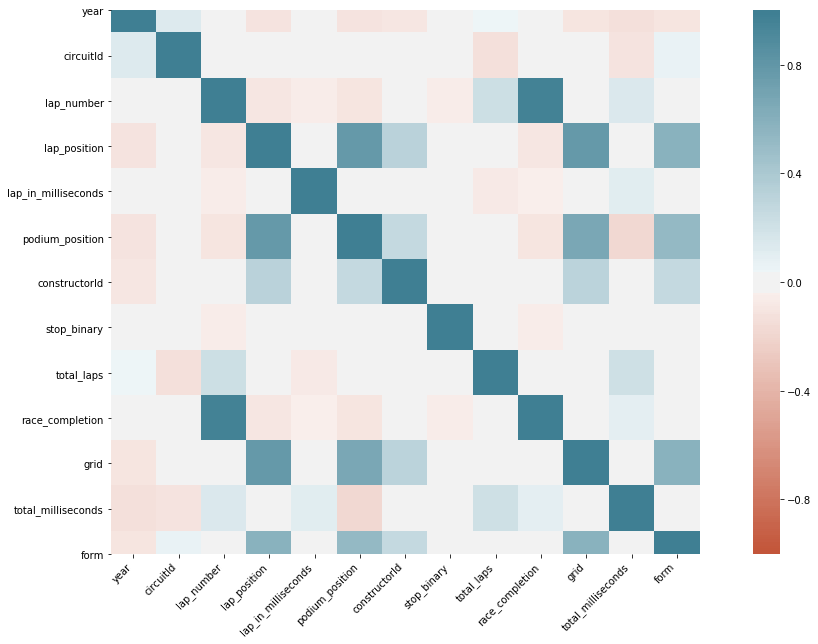

In [162]:
corr = alles.corr()
fig = plt.figure(figsize = (19,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#plt.title('Correlation Matrix\n', fontsize=16);

In [163]:
corr = alles.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,circuitId,lap_number,lap_position,lap_in_milliseconds,podium_position,constructorId,stop_binary,total_laps,race_completion,grid,total_milliseconds,form
year,1,0.124182,0.00999004,-0.117021,-0.0252329,-0.11044,-0.0920624,-0.012314,0.043046,-0.000309883,-0.103298,-0.122447,-0.103734
circuitId,0.124182,1,-0.0252628,-0.0148033,-0.00733702,-0.0223147,-0.00481293,-0.0144201,-0.129912,0.00476868,-0.0114661,-0.115232,0.0655469
lap_number,0.00999004,-0.0252628,1,-0.0935669,-0.0558683,-0.10418,-0.00965846,-0.0566283,0.221224,0.96314,-0.0293647,0.145459,-0.0101579
lap_position,-0.117021,-0.0148033,-0.0935669,1,0.016652,0.785372,0.324025,0.00681093,-0.000648291,-0.0953628,0.788331,-0.00959469,0.57871
lap_in_milliseconds,-0.0252329,-0.00733702,-0.0558683,0.016652,1,0.0153007,0.00814659,0.0208635,-0.0767452,-0.0418218,0.0147375,0.115022,0.00900969
podium_position,-0.11044,-0.0223147,-0.10418,0.785372,0.0153007,1,0.263902,0.0191073,0.00593685,-0.107772,0.675868,-0.182909,0.520232
constructorId,-0.0920624,-0.00481293,-0.00965846,0.324025,0.00814659,0.263902,1,0.000261745,-0.00423198,-0.00915231,0.318546,0.034099,0.260956
stop_binary,-0.012314,-0.0144201,-0.0566283,0.00681093,0.0208635,0.0191073,0.000261745,1,-0.0246468,-0.0541136,0.00579103,0.00368605,0.00504625
total_laps,0.043046,-0.129912,0.221224,-0.000648291,-0.0767452,0.00593685,-0.00423198,-0.0246468,1,-0.0113729,-0.0173356,0.215187,0.0331636
race_completion,-0.000309883,0.00476868,0.96314,-0.0953628,-0.0418218,-0.107772,-0.00915231,-0.0541136,-0.0113729,1,-0.0256209,0.0975033,-0.0174333


**Erstes Ergebnis:**
Korrelationen zwischen der Podiums Position und folgenden Features:
    1. lap_position: pro Runde Position
    2. grid: Startposition
    3. form: form des fahrers
    4. constructorId: Team

In [195]:
alles.columns

Index(['raceId', 'year', 'circuitId', 'grandprix_name', 'driverId',
       'lap_number', 'lap_position', 'lap_in_milliseconds', 'driver_fullname',
       'podium_position', 'constructorId', 'constructor_name', 'stop_binary',
       'total_laps', 'race_completion', 'grid', 'status_clean',
       'total_milliseconds', 'form'],
      dtype='object')

In [196]:
alles_dummies = pd.get_dummies(alles, columns=['raceId'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['circuitId'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['driverId'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['lap_position'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['constructorId'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['stop_binary'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['race_completion'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['grid'])
alles_dummies = pd.get_dummies(alles_dummies, columns=['status_clean'])






In [201]:
alles_dummies.drop(['grandprix_name','driver_fullname','constructor_name'], inplace = True, axis = 1)

In [202]:
alles_dummies.shape

(157755, 1246)

In [242]:
alles_dummies.to_csv("formula1_daten_dummies.csv", sep = ";", decimal = ".")

In [167]:
alles.to_csv("formula1_daten.csv", sep = ";", decimal = ".")

**Modelle dies das**

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [226]:
lol = list(alles_dummies.columns)
lol.remove("total_milliseconds")

In [244]:
import pytorch
pytorch.train(alles_dummies, good = True, fast = True, accuracy = "Excellent")

ModuleNotFoundError: No module named 'pytorch'

In [229]:
train, test = train_test_split(alles_dummies)
rows = [row for i, row in train[lol].iterrows()]
X = np.array(rows)
y = np.array(train["total_milliseconds"])

In [233]:
rows = [row for i, row in test[lol].iterrows()]
X_test = np.array(rows)
y_test = np.array(test["total_milliseconds"])

In [236]:
reg = LinearRegression().fit(X, y)
#reg.score(X, y)

In [239]:
A = reg.predict(X)
mse = mean_squared_error(A, y)

In [240]:
mse

229105241517.34027

In [212]:
A

array([5350181.99999998, 6692393.9220779 , 5641703.61428569, ...,
       6180836.84210524, 5580220.99999997, 7267097.74999998])

In [213]:
y

array([6583476.        , 5703565.62      , 7405063.        , ...,
       6232513.82352941, 6167771.51785714, 6123346.37681159])

In [215]:
A[1]- y_test[1]

-2.60770320892334e-08

<Figure size 1368x720 with 0 Axes>

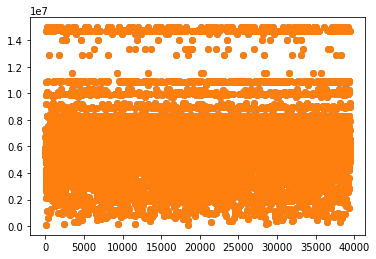

<Figure size 1368x720 with 0 Axes>

In [216]:
plt.plot(A,"o")
plt.plot(y_test, "o")
plt.figure(figsize = (19,10))